# Pre-Equilibrium Maximazation of Yield #

In [1]:
# make sure jupyter path is correct for loading local moudules
import sys
# path to steric_simulator module relative to notebook
sys.path.append("../../../")
import copy

In [2]:
from steric_free_simulator import ReactionNetwork, VectorizedRxnNet, VecSim, Optimizer, EquilibriumSolver

EnergyExplorer Module is not available. Check Rosetta installation. <ipykernel.iostream.OutStream object at 0x7efefa7a2e10>


We'll start with the AP2 complex that we've worked with before. Pairwise $\Delta Gs$ were derived from the PDB structures via Rossetta

In [3]:
base_input = '../../input_files/trimer.pwr'
rn = ReactionNetwork(base_input, one_step=True)
rn.resolve_tree()


['A']
['B']
['C']
-----
{'A'}
{'A'}
set()
-----
{'A'}
{'B'}
{'A'}
False
Allowed edges: 
('A', 'B')
Connected Nodes:  ['A', 'B']
Connected Edges:  [('A', 'B')]
Allowed edges: 
('A', 'C')
Allowed edges: 
('B', 'C')
New node added--1
['A', 'B']
{('A', 'B'): [None, None, 1, tensor([-50000.], dtype=torch.float64)], ('A', 'C'): [None, None, 1, tensor([-50000.], dtype=torch.float64)], ('B', 'C'): [None, None, 1, tensor([-50000.], dtype=torch.float64)]}
New node added--2
[0, 1, 2, 3]
-----
{'A'}
{'C'}
{'A'}
False
Allowed edges: 
('A', 'B')
Allowed edges: 
('A', 'C')
Connected Nodes:  ['A', 'C']
Connected Edges:  [('A', 'C')]
Allowed edges: 
('B', 'C')
New node added--1
['A', 'C']
{('A', 'B'): [None, None, 1, tensor([-50000.], dtype=torch.float64)], ('A', 'C'): [None, None, 1, tensor([-50000.], dtype=torch.float64)], ('B', 'C'): [None, None, 1, tensor([-50000.], dtype=torch.float64)]}
New node added--2
[0, 1, 2, 3, 4]
Allowed edges: 
('A', 'B')
Allowed edges: 
('A', 'C')
Allowed edges: 
('B', '

In [4]:
uid_dict = {}
sys.path.append("../../")
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    #print(n)
    #print(rn.network.nodes()[n])
    for k,v in rn.network[n].items():
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = (r1,r2)
        uid_dict[(n,k)] = uid

print(uid_dict)

{(0, 3): 0, (0, 4): 1, (0, 6): 5, (1, 3): 0, (1, 5): 2, (1, 6): 3, (2, 4): 1, (2, 5): 2, (2, 6): 4, (3, 6): 4, (4, 6): 3, (5, 6): 5}


In [5]:
#Changing Initial Conditions
import networkx as nx
#Changin k_on
new_kon = [1000.0,1000.0,1000.0,1000.0,1000.0,1000.0]*np.array([1e0])  #Poor yield Simruntime = 1sec

update_kon_dict = {}
for edge in rn.network.edges:
    print(rn.network.get_edge_data(edge[0],edge[1]))
    update_kon_dict[edge] = new_kon[uid_dict[edge]]

nx.set_edge_attributes(rn.network,update_kon_dict,'k_on')

# for edge in rn.network.edges:
#     print(rn.network.get_edge_data(edge[0],edge[1]))
vec_rn = VectorizedRxnNet(rn, dev='cpu',coupling=True,cid={0:4})
print(vec_rn.kon)

{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-50000.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-50000.], dtype=torch.float64), 'uid': 1}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-100000.], dtype=torch.float64), 'uid': 5}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-50000.], dtype=torch.float64), 'uid': 0}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-50000.], dtype=torch.float64), 'uid': 2}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-100000.], dtype=torch.float64), 'uid': 3}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-50000.], dtype=torch.float64), 'uid': 1}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-50000.], dtype=torch.float64), 'uid': 2}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-100000.], dtype=torch.float64), 'uid': 4}
{'k_on': 1.0, 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-100000.], dtype=to

## The Equilibrium Solution ##
First we will find the equilibrium solution for this system.

In [6]:
vec_rn.update_reaction_net(rn,1)
poly_system = EquilibriumSolver(rn)
solution = poly_system.solve()
if solution == None:
    print("No Equilibrium solution")
else:
    print(solution)
    print("Equilibrium expected yield: ", 100 * solution[-1] / min(vec_rn.initial_copies[:vec_rn.num_monomers]), '%')
print(vec_rn.kon)

No aceeptable solution found
No Equilibrium solution
tensor([1000., 1000., 1000., 1000., 1000., 1000.], dtype=torch.float64,
       grad_fn=<CopySlices>)


In [7]:
uid_dict = {}
sys.path.append("../")
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    #print(n)
    #print(rn.network.nodes()[n])
    for k,v in rn.network[n].items():
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = (r1,r2)
        uid_val = {'reactants':reactants,'kon':v['k_on'],'score':v['rxn_score'],'koff':v['k_off'],'uid':uid}
        if uid not in uid_dict.keys():
            uid_dict[uid] = uid_val
    print(gtostr(rn.network.nodes[n]['struct']))
    #for r_set in rn.get_reactant_sets(n):
    #    print(tuple(r_set))
    #print(rn.network[n]['struct'])
ind_sort = np.argsort(vec_rn.kon.detach().numpy())
for i in ind_sort:
    print(vec_rn.kon[i])
    print(uid_dict[i])

A
B
C
AB
AC
BC
ABC
tensor(1000., dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'A'}, {'B'}), 'kon': 999.9999999999998, 'score': tensor([-50000.], dtype=torch.float64), 'koff': 2.7423593919635816e-07, 'uid': 0}
tensor(1000., dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'A'}, {'C'}), 'kon': 999.9999999999998, 'score': tensor([-50000.], dtype=torch.float64), 'koff': 2.7423593919635816e-07, 'uid': 1}
tensor(1000., dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'B'}, {'C'}), 'kon': 999.9999999999998, 'score': tensor([-50000.], dtype=torch.float64), 'koff': 2.7423593919635816e-07, 'uid': 2}
tensor(1000., dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'B'}, {'C', 'A'}), 'kon': 999.9999999999998, 'score': tensor([-100000.], dtype=torch.float64), 'koff': 7.520535034690868e-17, 'uid': 3}
tensor(1000., dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'C'}, {'B', 'A'}), 'kon': 999.9999999999998, 'score': tensor([-1000

In [8]:
uid_dict = {}
sys.path.append("../")
import numpy as np
from reaction_network import gtostr
from torch import DoubleTensor as Tensor
import torch

node_map = {}
for node in rn.network.nodes():
    node_map[gtostr(rn.network.nodes[node]['struct'])] = node

print(node_map)

def get_max_edge(n):
    """
    Calculates the max rate (k_on) for a given node
    To find out the maximum flow path to the final complex starting from the current node.
    
    Can also calculate the total rate of consumption of a node by summing up all rates. 
    Can tell which component is used quickly.
    """
    try:
        edges = rn.network.out_edges(n)
        #Loop over all edges
        #Get attributes
        if len(edges)==0:
            return(False)
        kon_max = -1
        next_node = -1
        
        kon_sum = 0
        for edge in edges:
            data = rn.network.get_edge_data(edge[0],edge[1])
            #print(data)
            #Get uid
            uid = data['uid']
            #Get updated kon
            temp_kon = vec_rn.kon[uid]
            kon_sum+=temp_kon
            
            if temp_kon > kon_max:
                kon_max = temp_kon
                next_node=edge[1]
        return(kon_max,next_node,kon_sum)
    except Exception as err:
        raise(err)
def get_node_flux(n):
    total_flux_outedges = 0
    total_flux_inedges = 0
    #Go over all the out edges
    edges_out = rn.network.out_edges(n)
    if len(edges_out)>0:

        for edge in edges_out:
            data = rn.network.get_edge_data(edge[0],edge[1])
            #print(data)
            #Get uid
            uid = data['uid']

            #Get updated kon
            temp_kon = vec_rn.kon[uid]

            #Calculate k_off also
            std_c = Tensor([1.])
            l_kon = torch.log(temp_kon)
            l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
            koff = torch.exp(l_koff)

            #Getting conc. of reactants and products
            #Get product
            prod = gtostr(rn.network.nodes[edge[1]]['struct']) 
            #Get other reactant
            react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))

            #Net flux from this edge = Generation - consumption
            edge_flux = koff*solution[edge[1]] - temp_kon*(solution[edge[0]])*(solution[node_map[react]])
            #edge_flux = koff*vec_rn.copies_vec[edge[1]] 

            print("Reaction: ", gtostr(rn.network.nodes[edge[0]]['struct']), "+",react," -> ",prod)
            print("Net flux: ",edge_flux)
            print("kon : ",temp_kon)
            print("koff: ",koff)
            print("Free Energy: ",vec_rn.rxn_score_vec[uid])
            print("Reaction data OUTWARD: ")
            print(data)

            total_flux_outedges+=edge_flux
    
    #Now go over all the in edges
    edges_in = rn.network.in_edges(n)
    react_list = []
    if len(edges_in) > 0:
        for edge in edges_in:
            if edge[0] in react_list:
                continue
            data = rn.network.get_edge_data(edge[0],edge[1])
            uid = data['uid']


            #Get generation rates; which would be kon
            temp_kon = vec_rn.kon[uid]

            #Get consumption rates; which is k_off
            std_c = Tensor([1.])
            l_kon = torch.log(temp_kon)
            l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
            koff = torch.exp(l_koff)

            #Get conc. of reactants and products
            prod = gtostr(rn.network.nodes[edge[1]]['struct'])
            #Get other reactant
            react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))
            react_list.append(node_map[react])
            #Net flux from this edge = Generation - consumption
            edge_flux_in = temp_kon*(solution[edge[0]])*(solution[node_map[react]])- koff*solution[edge[1]]
            #edge_flux_in = koff*vec_rn.copies_vec[edge[1]]
            


            print("Reaction: ", prod ," -> ",gtostr(rn.network.nodes[edge[0]]['struct']), "+",react)
            print("Net flux: ",edge_flux_in)
            print("kon : ",temp_kon)
            print("koff: ",koff)
            print("Raction data INWARD: ")
            print(data)

            total_flux_inedges+=edge_flux_in
    net_node_flux = total_flux_outedges + total_flux_inedges
    
    return(net_node_flux)
pathway = []
kon_sumarray = []
total_con_rate = {}
net_flux = {}

if solution != None:
    for n in rn.network.nodes():

        n_str = gtostr(rn.network.nodes[n]['struct']) 

        paths = [n_str]
        kon_sum = 0
        temp_node = n
        max_edge = True
        consumption_rate = 0
        if n < len(rn.network.nodes()):#num_monomers:
    #         print("Current node: ")
    #         print(n_str)
            while max_edge:
                max_edge = get_max_edge(temp_node)
                if max_edge:
                    total_con_rate[gtostr(rn.network.nodes[temp_node]['struct'])] = max_edge[2]
                    temp_node = max_edge[1]
                    kon_sum += max_edge[0].item()


    #                 print("Next node: ")
    #                 print(temp_node)

                    paths.append(gtostr(rn.network.nodes[temp_node]['struct']))
                else:
                    break
            pathway.append(paths)
            kon_sumarray.append(kon_sum)
            paths=[]

        print("-------------------------------------------------------------------------------")
        print("-------------------------------------------------------------------------------")
        print("|                                                                             |")
        node_flux = get_node_flux(n)
        net_flux[gtostr(rn.network.nodes[n]['struct'])] = node_flux
        print("|                                                                             |")
        print("-------------------------------------------------------------------------------")
        print("-------------------------------------------------------------------------------")

    print(pathway)
    print(kon_sumarray)
    #print(total_con_rate)

{'A': 0, 'B': 1, 'C': 2, 'AB': 3, 'AC': 4, 'BC': 5, 'ABC': 6}


In [9]:
if solution != None:
    for k,v in sorted(total_con_rate.items(),key=lambda x : x[1]):
        print(k," : ", v.item())

In [10]:
if solution !=None:
    for k,v in sorted(net_flux.items(),key=lambda x : x[1]):
        print(k," : ", v)



## Using the optimizer with a 1 second simulation runtime ##

In [11]:
vec_rn.reset(reset_params=True)
optim = Optimizer(reaction_network=vec_rn,
                  sim_runtime=1,
                  optim_iterations=10000,
                  learning_rate=1,
                  device='cpu')
optim.rn.update_reaction_net(rn)
optim.optimize()

Using CPU
Reaction Parameters before optimization: 
[Parameter containing:
tensor([1000., 1000., 1000., 1000., 1000.], dtype=torch.float64,
       requires_grad=True)]
Using CPU
Next time:  tensor(163297.0706, dtype=torch.float64, grad_fn=<AddBackward0>)
Type/class of yield:  <class 'torch.Tensor'>
yield on sim iteration 0 was 57.0%
Previous reaction rates:  tensor([1000., 1000., 1000., 1000., 1000., 1000.], dtype=torch.float64)
New reaction rates: tensor([1000., 1000., 1000., 1000., 1000., 1000.], dtype=torch.float64)
current params: tensor([1000., 1000., 1000., 1000., 1000.], dtype=torch.float64)
Using CPU
Next time:  tensor(163297.0706, dtype=torch.float64, grad_fn=<AddBackward0>)
Type/class of yield:  <class 'torch.Tensor'>
yield on sim iteration 1 was 57.0%
Previous reaction rates:  tensor([1000., 1000., 1000., 1000., 1000., 1000.], dtype=torch.float64)
New reaction rates: tensor([ 999.0427,  999.0001,  999.0001, 1000.9999,  999.0427, 1000.9999],
       dtype=torch.float64)
curren

Next time:  tensor(167176.0836, dtype=torch.float64, grad_fn=<AddBackward0>)
Type/class of yield:  <class 'torch.Tensor'>
yield on sim iteration 16 was 57.4%
Previous reaction rates:  tensor([ 984.8825,  984.9965,  984.9960, 1014.9897,  984.8825, 1014.9908],
       dtype=torch.float64)
New reaction rates: tensor([ 983.7905,  983.9956,  983.9951, 1015.9880,  983.7905, 1015.9892],
       dtype=torch.float64)
current params: tensor([ 983.9956,  983.9951, 1015.9880,  983.7905, 1015.9892],
       dtype=torch.float64)
Using CPU
Next time:  tensor(167444.8170, dtype=torch.float64, grad_fn=<AddBackward0>)
Type/class of yield:  <class 'torch.Tensor'>
yield on sim iteration 17 was 57.4%
Previous reaction rates:  tensor([ 983.7905,  983.9956,  983.9951, 1015.9880,  983.7905, 1015.9892],
       dtype=torch.float64)
New reaction rates: tensor([ 982.6864,  982.9945,  982.9940, 1016.9860,  982.6864, 1016.9873],
       dtype=torch.float64)
current params: tensor([ 982.9945,  982.9940, 1016.9860,  982.

Next time:  tensor(171651.5551, dtype=torch.float64, grad_fn=<AddBackward0>)
Type/class of yield:  <class 'torch.Tensor'>
yield on sim iteration 32 was 57.8%
Previous reaction rates:  tensor([ 965.9345,  968.9689,  968.9675, 1030.9348,  965.9345, 1030.9375],
       dtype=torch.float64)
New reaction rates: tensor([ 964.6471,  967.9665,  967.9650, 1031.9292,  964.6471, 1031.9321],
       dtype=torch.float64)
current params: tensor([ 967.9665,  967.9650, 1031.9292,  964.6471, 1031.9321],
       dtype=torch.float64)
Using CPU
Next time:  tensor(171944.0946, dtype=torch.float64, grad_fn=<AddBackward0>)
Type/class of yield:  <class 'torch.Tensor'>
yield on sim iteration 33 was 57.9%
Previous reaction rates:  tensor([ 964.6471,  967.9665,  967.9650, 1031.9292,  964.6471, 1031.9321],
       dtype=torch.float64)
New reaction rates: tensor([ 963.3482,  966.9640,  966.9625, 1032.9234,  963.3482, 1032.9264],
       dtype=torch.float64)
current params: tensor([ 966.9640,  966.9625, 1032.9234,  963.

Next time:  tensor(176516.6543, dtype=torch.float64, grad_fn=<AddBackward0>)
Type/class of yield:  <class 'torch.Tensor'>
yield on sim iteration 48 was 58.3%
Previous reaction rates:  tensor([ 944.0403,  952.9305,  952.9275, 1046.8136,  944.0403, 1046.8182],
       dtype=torch.float64)
New reaction rates: tensor([ 942.5880,  951.9286,  951.9254, 1047.8037,  942.5880, 1047.8085],
       dtype=torch.float64)
current params: tensor([ 951.9286,  951.9254, 1047.8037,  942.5880, 1047.8085],
       dtype=torch.float64)
Using CPU
Next time:  tensor(176833.7563, dtype=torch.float64, grad_fn=<AddBackward0>)
Type/class of yield:  <class 'torch.Tensor'>
yield on sim iteration 49 was 58.3%
Previous reaction rates:  tensor([ 942.5880,  951.9286,  951.9254, 1047.8037,  942.5880, 1047.8085],
       dtype=torch.float64)
New reaction rates: tensor([ 941.1268,  950.9268,  950.9235, 1048.7936,  941.1268, 1048.7985],
       dtype=torch.float64)
current params: tensor([ 950.9268,  950.9235, 1048.7936,  941.

Previous reaction rates:  tensor([ 919.8436,  936.9217,  936.9159, 1062.6253,  919.8436, 1062.6315],
       dtype=torch.float64)
New reaction rates: tensor([ 918.2708,  935.9232,  935.9172, 1063.6115,  918.2708, 1063.6177],
       dtype=torch.float64)
current params: tensor([ 935.9232,  935.9172, 1063.6115,  918.2708, 1063.6177],
       dtype=torch.float64)
Using CPU
Next time:  tensor(182113.7102, dtype=torch.float64, grad_fn=<AddBackward0>)
Type/class of yield:  <class 'torch.Tensor'>
yield on sim iteration 65 was 58.8%
Previous reaction rates:  tensor([ 918.2708,  935.9232,  935.9172, 1063.6115,  918.2708, 1063.6177],
       dtype=torch.float64)
New reaction rates: tensor([ 916.6918,  934.9250,  934.9187, 1064.5974,  916.6918, 1064.6037],
       dtype=torch.float64)
current params: tensor([ 934.9250,  934.9187, 1064.5974,  916.6918, 1064.6037],
       dtype=torch.float64)
Using CPU
Next time:  tensor(182456.5414, dtype=torch.float64, grad_fn=<AddBackward0>)
Type/class of yield:  <cl

Next time:  tensor(187414.5577, dtype=torch.float64, grad_fn=<AddBackward0>)
Type/class of yield:  <class 'torch.Tensor'>
yield on sim iteration 80 was 59.2%
Previous reaction rates:  tensor([ 894.0055,  920.9879,  920.9779, 1078.3764,  894.0055, 1078.3833],
       dtype=torch.float64)
New reaction rates: tensor([ 892.3482,  919.9955,  919.9852, 1079.3590,  892.3482, 1079.3659],
       dtype=torch.float64)
current params: tensor([ 919.9955,  919.9852, 1079.3590,  892.3482, 1079.3659],
       dtype=torch.float64)
Using CPU
Next time:  tensor(187780.0591, dtype=torch.float64, grad_fn=<AddBackward0>)
Type/class of yield:  <class 'torch.Tensor'>
yield on sim iteration 81 was 59.2%
Previous reaction rates:  tensor([ 892.3482,  919.9955,  919.9852, 1079.3590,  892.3482, 1079.3659],
       dtype=torch.float64)
New reaction rates: tensor([ 890.6865,  919.0036,  918.9929, 1080.3414,  890.6865, 1080.3483],
       dtype=torch.float64)
current params: tensor([ 919.0036,  918.9929, 1080.3414,  890.

Next time:  tensor(193447.1552, dtype=torch.float64, grad_fn=<AddBackward0>)
Type/class of yield:  <class 'torch.Tensor'>
yield on sim iteration 96 was 59.7%
Previous reaction rates:  tensor([ 867.0119,  905.1708,  905.1544, 1094.0736,  867.0119, 1094.0800],
       dtype=torch.float64)
New reaction rates: tensor([ 865.2944,  904.1870,  904.1701, 1095.0530,  865.2944, 1095.0593],
       dtype=torch.float64)
current params: tensor([ 904.1870,  904.1701, 1095.0530,  865.2944, 1095.0593],
       dtype=torch.float64)
Using CPU
Next time:  tensor(193837.4304, dtype=torch.float64, grad_fn=<AddBackward0>)
Type/class of yield:  <class 'torch.Tensor'>
yield on sim iteration 97 was 59.7%
Previous reaction rates:  tensor([ 865.2944,  904.1870,  904.1701, 1095.0530,  865.2944, 1095.0593],
       dtype=torch.float64)
New reaction rates: tensor([ 863.5738,  903.2038,  903.1864, 1096.0322,  863.5738, 1096.0385],
       dtype=torch.float64)
current params: tensor([ 903.2038,  903.1864, 1096.0322,  863.

Next time:  tensor(199884.5258, dtype=torch.float64, grad_fn=<AddBackward0>)
Type/class of yield:  <class 'torch.Tensor'>
yield on sim iteration 112 was 60.2%
Previous reaction rates:  tensor([ 839.1792,  889.5084,  889.4828, 1109.7216,  839.1792, 1109.7263],
       dtype=torch.float64)
New reaction rates: tensor([ 837.4168,  888.5355,  888.5092, 1110.6980,  837.4168, 1110.7026],
       dtype=torch.float64)
current params: tensor([ 888.5355,  888.5092, 1110.6980,  837.4168, 1110.7026],
       dtype=torch.float64)
Using CPU
Next time:  tensor(200300.7972, dtype=torch.float64, grad_fn=<AddBackward0>)
Type/class of yield:  <class 'torch.Tensor'>
yield on sim iteration 113 was 60.2%
Previous reaction rates:  tensor([ 837.4168,  888.5355,  888.5092, 1110.6980,  837.4168, 1110.7026],
       dtype=torch.float64)
New reaction rates: tensor([ 835.6518,  887.5633,  887.5364, 1111.6743,  835.6518, 1111.6787],
       dtype=torch.float64)
current params: tensor([ 887.5633,  887.5364, 1111.6743,  83

Next time:  tensor(206750.4277, dtype=torch.float64, grad_fn=<AddBackward0>)
Type/class of yield:  <class 'torch.Tensor'>
yield on sim iteration 128 was 60.7%
Previous reaction rates:  tensor([ 810.7025,  874.0381,  873.9994, 1125.3234,  810.7025, 1125.3254],
       dtype=torch.float64)
New reaction rates: tensor([ 808.9043,  873.0785,  873.0388, 1126.2970,  808.9043, 1126.2988],
       dtype=torch.float64)
current params: tensor([ 873.0785,  873.0388, 1126.2970,  808.9043, 1126.2988],
       dtype=torch.float64)
Using CPU
Next time:  tensor(207194.4657, dtype=torch.float64, grad_fn=<AddBackward0>)
Type/class of yield:  <class 'torch.Tensor'>
yield on sim iteration 129 was 60.7%
Previous reaction rates:  tensor([ 808.9043,  873.0785,  873.0388, 1126.2970,  808.9043, 1126.2988],
       dtype=torch.float64)
New reaction rates: tensor([ 807.1041,  872.1198,  872.0791, 1127.2705,  807.1041, 1127.2720],
       dtype=torch.float64)
current params: tensor([ 872.1198,  872.0791, 1127.2705,  80

Next time:  tensor(214076.9810, dtype=torch.float64, grad_fn=<AddBackward0>)
Type/class of yield:  <class 'torch.Tensor'>
yield on sim iteration 144 was 61.2%
Previous reaction rates:  tensor([ 781.6982,  858.7995,  858.7424, 1140.8805,  781.6982, 1140.8790],
       dtype=torch.float64)
New reaction rates: tensor([ 779.8696,  857.8558,  857.7973, 1141.8514,  779.8696, 1141.8496],
       dtype=torch.float64)
current params: tensor([ 857.8558,  857.7973, 1141.8514,  779.8696, 1141.8496],
       dtype=torch.float64)
Using CPU
Next time:  tensor(214551.0575, dtype=torch.float64, grad_fn=<AddBackward0>)
Type/class of yield:  <class 'torch.Tensor'>
yield on sim iteration 145 was 61.2%
Previous reaction rates:  tensor([ 779.8696,  857.8558,  857.7973, 1141.8514,  779.8696, 1141.8496],
       dtype=torch.float64)
New reaction rates: tensor([ 778.0393,  856.9131,  856.8532, 1142.8220,  778.0393, 1142.8200],
       dtype=torch.float64)
current params: tensor([ 856.9131,  856.8532, 1142.8220,  77

Next time:  tensor(221904.2431, dtype=torch.float64, grad_fn=<AddBackward0>)
Type/class of yield:  <class 'torch.Tensor'>
yield on sim iteration 160 was 61.7%
Previous reaction rates:  tensor([ 752.2326,  843.8366,  843.7540, 1156.3930,  752.2326, 1156.3878],
       dtype=torch.float64)
New reaction rates: tensor([ 750.3766,  842.9117,  842.8272, 1157.3610,  750.3766, 1157.3556],
       dtype=torch.float64)
current params: tensor([ 842.9117,  842.8272, 1157.3610,  750.3766, 1157.3556],
       dtype=torch.float64)
Using CPU
Next time:  tensor(222411.1273, dtype=torch.float64, grad_fn=<AddBackward0>)
Type/class of yield:  <class 'torch.Tensor'>
yield on sim iteration 161 was 61.7%
Previous reaction rates:  tensor([ 750.3766,  842.9117,  842.8272, 1157.3610,  750.3766, 1157.3556],
       dtype=torch.float64)
New reaction rates: tensor([ 748.5189,  841.9881,  841.9017, 1158.3289,  748.5189, 1158.3233],
       dtype=torch.float64)
current params: tensor([ 841.9881,  841.9017, 1158.3289,  74

Next time:  tensor(230280.4637, dtype=torch.float64, grad_fn=<AddBackward0>)
Type/class of yield:  <class 'torch.Tensor'>
yield on sim iteration 176 was 62.3%
Previous reaction rates:  tensor([ 722.3399,  829.2003,  829.0827, 1171.8598,  722.3399, 1171.8516],
       dtype=torch.float64)
New reaction rates: tensor([ 720.4578,  828.2976,  828.1775, 1172.8249,  720.4578, 1172.8165],
       dtype=torch.float64)
current params: tensor([ 828.2976,  828.1775, 1172.8249,  720.4578, 1172.8165],
       dtype=torch.float64)
Using CPU
Next time:  tensor(230823.4608, dtype=torch.float64, grad_fn=<AddBackward0>)
Type/class of yield:  <class 'torch.Tensor'>
yield on sim iteration 177 was 62.3%
Previous reaction rates:  tensor([ 720.4578,  828.2976,  828.1775, 1172.8249,  720.4578, 1172.8165],
       dtype=torch.float64)
New reaction rates: tensor([ 718.5742,  827.3965,  827.2738, 1173.7898,  718.5742, 1173.7813],
       dtype=torch.float64)
current params: tensor([ 827.3965,  827.2738, 1173.7898,  71

Next time:  tensor(239262.9964, dtype=torch.float64, grad_fn=<AddBackward0>)
Type/class of yield:  <class 'torch.Tensor'>
yield on sim iteration 192 was 62.9%
Previous reaction rates:  tensor([ 692.0336,  814.9502,  814.7851, 1187.2783,  692.0336, 1187.2688],
       dtype=torch.float64)
New reaction rates: tensor([ 690.1258,  814.0739,  813.9054, 1188.2403,  690.1258, 1188.2307],
       dtype=torch.float64)
current params: tensor([ 814.0739,  813.9054, 1188.2403,  690.1258, 1188.2307],
       dtype=torch.float64)
Using CPU
Next time:  tensor(239846.0255, dtype=torch.float64, grad_fn=<AddBackward0>)
Type/class of yield:  <class 'torch.Tensor'>
yield on sim iteration 193 was 62.9%
Previous reaction rates:  tensor([ 690.1258,  814.0739,  813.9054, 1188.2403,  690.1258, 1188.2307],
       dtype=torch.float64)
New reaction rates: tensor([ 688.2164,  813.1995,  813.0274, 1189.2021,  688.2164, 1189.1925],
       dtype=torch.float64)
current params: tensor([ 813.1995,  813.0274, 1189.2021,  68

Next time:  tensor(248919.9042, dtype=torch.float64, grad_fn=<AddBackward0>)
Type/class of yield:  <class 'torch.Tensor'>
yield on sim iteration 208 was 63.5%
Previous reaction rates:  tensor([ 661.3133,  801.1570,  800.9278, 1202.6447,  661.3133, 1202.6366],
       dtype=torch.float64)
New reaction rates: tensor([ 659.3794,  800.3120,  800.0781, 1203.6032,  659.3794, 1203.5954],
       dtype=torch.float64)
current params: tensor([ 800.3120,  800.0781, 1203.6032,  659.3794, 1203.5954],
       dtype=torch.float64)
Using CPU
Next time:  tensor(249547.6257, dtype=torch.float64, grad_fn=<AddBackward0>)
Type/class of yield:  <class 'torch.Tensor'>
yield on sim iteration 209 was 63.5%
Previous reaction rates:  tensor([ 659.3794,  800.3120,  800.0781, 1203.6032,  659.3794, 1203.5954],
       dtype=torch.float64)
New reaction rates: tensor([ 657.4437,  799.4690,  799.2304, 1204.5615,  657.4437, 1204.5540],
       dtype=torch.float64)
current params: tensor([ 799.4690,  799.2304, 1204.5615,  65

Using CPU
Next time:  tensor(259332.4139, dtype=torch.float64, grad_fn=<AddBackward0>)
Type/class of yield:  <class 'torch.Tensor'>
yield on sim iteration 224 was 64.1%
Previous reaction rates:  tensor([ 630.1691,  787.9049,  787.5895, 1217.9528,  630.1691, 1217.9508],
       dtype=torch.float64)
New reaction rates: tensor([ 628.2082,  787.0968,  786.7751, 1218.9074,  628.2082, 1218.9060],
       dtype=torch.float64)
current params: tensor([ 787.0968,  786.7751, 1218.9074,  628.2082, 1218.9060],
       dtype=torch.float64)
Using CPU
Next time:  tensor(260010.4165, dtype=torch.float64, grad_fn=<AddBackward0>)
Type/class of yield:  <class 'torch.Tensor'>
yield on sim iteration 225 was 64.2%
Previous reaction rates:  tensor([ 628.2082,  787.0968,  786.7751, 1218.9074,  628.2082, 1218.9060],
       dtype=torch.float64)
New reaction rates: tensor([ 626.2455,  786.2912,  785.9631, 1219.8618,  626.2455, 1219.8609],
       dtype=torch.float64)
current params: tensor([ 786.2912,  785.9631, 1219

Next time:  tensor(270598.5381, dtype=torch.float64, grad_fn=<AddBackward0>)
Type/class of yield:  <class 'torch.Tensor'>
yield on sim iteration 240 was 64.8%
Previous reaction rates:  tensor([ 598.5846,  775.2938,  774.8632, 1233.1943,  598.5846, 1233.2046],
       dtype=torch.float64)
New reaction rates: tensor([ 596.5955,  774.5295,  774.0906, 1234.1445,  596.5955, 1234.1557],
       dtype=torch.float64)
current params: tensor([ 774.5295,  774.0906, 1234.1445,  596.5955, 1234.1557],
       dtype=torch.float64)
Using CPU
Next time:  tensor(271333.6151, dtype=torch.float64, grad_fn=<AddBackward0>)
Type/class of yield:  <class 'torch.Tensor'>
yield on sim iteration 241 was 64.9%
Previous reaction rates:  tensor([ 596.5955,  774.5295,  774.0906, 1234.1445,  596.5955, 1234.1557],
       dtype=torch.float64)
New reaction rates: tensor([ 594.6046,  773.7682,  773.3207, 1235.0943,  594.6046, 1235.1066],
       dtype=torch.float64)
current params: tensor([ 773.7682,  773.3207, 1235.0943,  59

In [12]:
print(optim.yield_per_iter[-1])

0.6540759470671368


In [13]:
uid_dict = {}
sys.path.append("../")
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    #print(n)
    #print(rn.network.nodes()[n])
    for k,v in rn.network[n].items():
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = (r1,r2)
        uid_val = {'reactants':reactants,'kon':v['k_on'],'score':v['rxn_score'],'koff':v['k_off'],'uid':uid}
        if uid not in uid_dict.keys():
            uid_dict[uid] = uid_val
    print(gtostr(rn.network.nodes[n]['struct']))
    #for r_set in rn.get_reactant_sets(n):
    #    print(tuple(r_set))
    #print(rn.network[n]['struct'])
ind_sort = np.argsort(vec_rn.kon.detach().numpy())
for i in ind_sort:
    print(vec_rn.kon[i])
    print(uid_dict[i])

A
B
C
AB
AC
BC
ABC
tensor(572.5839, dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'A'}, {'B'}), 'kon': 999.9999999999998, 'score': tensor([-50000.], dtype=torch.float64), 'koff': 2.7423593919635816e-07, 'uid': 0}
tensor(572.5839, dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'C'}, {'B', 'A'}), 'kon': 999.9999999999998, 'score': tensor([-100000.], dtype=torch.float64), 'koff': 7.520535034690868e-17, 'uid': 4}
tensor(765.0491, dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'B'}, {'C'}), 'kon': 999.9999999999998, 'score': tensor([-50000.], dtype=torch.float64), 'koff': 2.7423593919635816e-07, 'uid': 2}
tensor(765.6008, dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'A'}, {'C'}), 'kon': 999.9999999999998, 'score': tensor([-50000.], dtype=torch.float64), 'koff': 2.7423593919635816e-07, 'uid': 1}
tensor(1245.5211, dtype=torch.float64, grad_fn=<SelectBackward>)
{'reactants': ({'B'}, {'C', 'A'}), 'kon': 999.9999999999998, 'score

In [14]:
uid_dict = {}
sys.path.append("../")
import numpy as np
from reaction_network import gtostr
from torch import DoubleTensor as Tensor
import torch

node_map = {}
for node in rn.network.nodes():
    node_map[gtostr(rn.network.nodes[node]['struct'])] = node

print(node_map)

def get_max_edge(n):
    """
    Calculates the max rate (k_on) for a given node
    To find out the maximum flow path to the final complex starting from the current node.
    
    Can also calculate the total rate of consumption of a node by summing up all rates. 
    Can tell which component is used quickly.
    """
    try:
        edges = rn.network.out_edges(n)
        #Loop over all edges
        #Get attributes
        kon_max = -1
        next_node = -1

        kon_sum = 0
        total_flux_outedges = 0
        total_flux_inedges = 0
        if len(edges)==0:
            return(False)
            
        for edge in edges:
            data = rn.network.get_edge_data(edge[0],edge[1])
            #print(data)
            #Get uid
            uid = data['uid']

            #Get updated kon
            temp_kon = vec_rn.kon[uid]
            kon_sum+=temp_kon
            
            if temp_kon > kon_max:
                kon_max = temp_kon
                next_node=edge[1]
             
        return(kon_max,next_node,kon_sum)
    except Exception as err:
        raise(err)

        
def get_node_flux(n):
    total_flux_outedges = 0
    total_flux_inedges = 0
    #Go over all the out edges
    edges_out = rn.network.out_edges(n)
    if len(edges_out)>0:

        for edge in edges_out:
            data = rn.network.get_edge_data(edge[0],edge[1])
            #print(data)
            #Get uid
            uid = data['uid']

            #Get updated kon
            temp_kon = vec_rn.kon[uid]

            #Calculate k_off also
            std_c = Tensor([1.])
            l_kon = torch.log(temp_kon)
            l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
            koff = torch.exp(l_koff)

            #Getting conc. of reactants and products
            #Get product
            prod = gtostr(rn.network.nodes[edge[1]]['struct']) 
            #Get other reactant
            react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))

            #Net flux from this edge = Generation - consumption
            edge_flux = koff*vec_rn.copies_vec[edge[1]] - temp_kon*(vec_rn.copies_vec[edge[0]])*(vec_rn.copies_vec[node_map[react]])
            #edge_flux = koff*vec_rn.copies_vec[edge[1]] 

            print("Reaction: ", gtostr(rn.network.nodes[edge[0]]['struct']), "+",react," -> ",prod)
            print("Net flux: ",edge_flux)
            print("kon : ",temp_kon)
            print("koff: ",koff)
            print("Reaction data OUTWARD: ")
            print(data)

            total_flux_outedges+=edge_flux
    
    #Now go over all the in edges
    edges_in = rn.network.in_edges(n)
    react_list = []
    if len(edges_in) > 0:
        for edge in edges_in:
            if edge[0] in react_list:
                continue
            data = rn.network.get_edge_data(edge[0],edge[1])
            uid = data['uid']


            #Get generation rates; which would be kon
            temp_kon = vec_rn.kon[uid]

            #Get consumption rates; which is k_off
            std_c = Tensor([1.])
            l_kon = torch.log(temp_kon)
            l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
            koff = torch.exp(l_koff)

            #Get conc. of reactants and products
            prod = gtostr(rn.network.nodes[edge[1]]['struct'])
            #Get other reactant
            react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))
            react_list.append(node_map[react])
            #Net flux from this edge = Generation - consumption
            edge_flux_in = temp_kon*(vec_rn.copies_vec[edge[0]])*(vec_rn.copies_vec[node_map[react]])- koff*vec_rn.copies_vec[edge[1]]
            #edge_flux_in = koff*vec_rn.copies_vec[edge[1]]
            


            print("Reaction: ", prod ," -> ",gtostr(rn.network.nodes[edge[0]]['struct']), "+",react)
            print("Net flux: ",edge_flux_in)
            print("kon : ",temp_kon)
            print("koff: ",koff)
            print("Raction data INWARD: ")
            print(data)

            total_flux_inedges+=edge_flux_in
    net_node_flux = total_flux_outedges + total_flux_inedges
    
    return(net_node_flux)
    
pathway = []
kon_sumarray = []
total_con_rate = {}
net_flux = {}
for n in rn.network.nodes():
    
    n_str = gtostr(rn.network.nodes[n]['struct']) 
    
    paths = [n_str]
    kon_sum = 0
    temp_node = n
    max_edge = True
    consumption_rate = 0
    if n < len(rn.network.nodes()):#num_monomers:
#         print("Current node: ")
#         print(n_str)
        while max_edge:
            max_edge = get_max_edge(temp_node)
            if max_edge:
                total_con_rate[gtostr(rn.network.nodes[temp_node]['struct'])] = max_edge[2]
                
                temp_node = max_edge[1]
                kon_sum += max_edge[0].item()
                
                
#                 print("Next node: ")
#                 print(temp_node)

                paths.append(gtostr(rn.network.nodes[temp_node]['struct']))
            else:
                break
        pathway.append(paths)
        kon_sumarray.append(kon_sum)
        paths=[]
    print("-------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------")
    print("|                                                                             |")
    node_flux = get_node_flux(n)
    net_flux[gtostr(rn.network.nodes[n]['struct'])] = node_flux
    print("|                                                                             |")
    print("-------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------")

print(pathway)
print(kon_sumarray)

#print(total_con_rate)

{'A': 0, 'B': 1, 'C': 2, 'AB': 3, 'AC': 4, 'BC': 5, 'ABC': 6}
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
|                                                                             |
Reaction:  A + B  ->  AB
Net flux:  tensor([2.7159e-07], dtype=torch.float64, grad_fn=<SubBackward0>)
kon :  tensor(572.5839, dtype=torch.float64, grad_fn=<SelectBackward>)
koff:  tensor([1.5702e-07], dtype=torch.float64, grad_fn=<ExpBackward>)
Reaction data OUTWARD: 
{'k_on': 999.9999999999998, 'k_off': 2.7423593919635816e-07, 'lcf': 1, 'rxn_score': tensor([-50000.], dtype=torch.float64), 'uid': 0}
Reaction:  A + C  ->  AC
Net flux:  tensor([3.6314e-07], dtype=torch.float64, grad_fn=<SubBackward0>)
kon :  tensor(765.6008, dtype=torch.float64, grad_fn=<SelectBackward>)
koff:  tensor([2.0996e-07], dtype=torch.float64, grad_fn=<ExpBackward>)
Reaction data OUTWARD: 
{'k_on': 999.9999999999998

In [15]:
for k,v in sorted(total_con_rate.items(),key=lambda x : x[1]):
    print(k," : ", v.item())

AB  :  572.5838688995566
AC  :  1245.5211250612556
BC  :  1245.547564520932
C  :  2103.233693120377
B  :  2583.1540669696865
A  :  2583.732184632435


In [16]:
for k,v in sorted(net_flux.items(),key=lambda x : x[1]):
    print(k," : ", v)

print(vec_rn.copies_vec)

AC  :  tensor([-9.9940e-07], dtype=torch.float64, grad_fn=<AddBackward0>)
BC  :  tensor([-9.9940e-07], dtype=torch.float64, grad_fn=<AddBackward0>)
AB  :  tensor([-3.4037e-07], dtype=torch.float64, grad_fn=<AddBackward0>)
B  :  tensor([-1.7849e-09], dtype=torch.float64, grad_fn=<AddBackward0>)
A  :  tensor([-1.7844e-09], dtype=torch.float64, grad_fn=<AddBackward0>)
C  :  tensor([6.5724e-07], dtype=torch.float64, grad_fn=<AddBackward0>)
ABC  :  tensor([1.3416e-06], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([2.9546e-10, 2.9535e-10, 6.9452e-11, 1.7296e+00, 1.7296e+00, 1.7296e+00,
        6.5408e+00], dtype=torch.float64, grad_fn=<MaxBackward2>)


In [17]:
for n in rn.network.nodes():
    print(gtostr(rn.network.nodes[n]['struct']), " : ", n)

A  :  0
B  :  1
C  :  2
AB  :  3
AC  :  4
BC  :  5
ABC  :  6


Let's first visualize some of the data.

**Without any optimization**


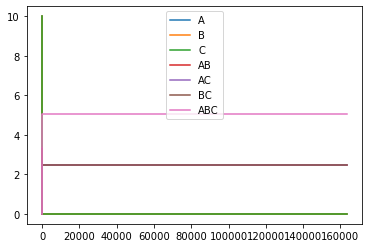

In [18]:
nodes_list = ['A','B','C','ABC','AB','BC','AC']
#nodes_list = ['AB','BMS','ABS','AMS','ABMS','AM','BM','MS']
optim.plot_observable(0,nodes_list)


**After 750 optimization iterations**


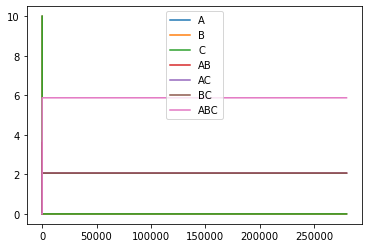

In [19]:

optim.plot_observable(-1,nodes_list)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

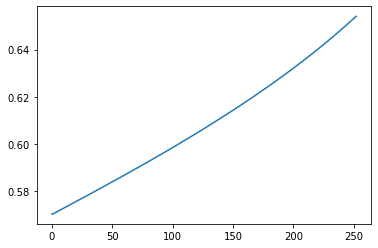

In [20]:
optim.plot_yield()

It seems like we've found a stable solution that produces greater yield than equilibrium. This should be thermodynamically
impossible. Let's try to find an explanation. We'll run simulations using the learned optimal parameters at a few different
timescales.

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(1, 4)
optim_rn = optim.rn
for i, runtime in enumerate([1, 5, 10]):
    optim_rn.reset()
    sim = VecSim(optim_rn, runtime, device='cpu')
    y = sim.simulate()
    sim.plot_observable(nodes_list,ax=ax[i])
    ax[i].set_title("runtime: " + str(runtime) + " seconds")
fig.set_size_inches(18, 6)
plt.show()

In [ ]:
def get_max_edge(n):
    """
    Calculates the max rate (k_on) for a given node
    To find out the maximum flow path to the final complex starting from the current node.
    
    Can also calculate the total rate of consumption of a node by summing up all rates. 
    Can tell which component is used quickly.
    """
    try:
        edges = rn.network.out_edges(n)
        #Loop over all edges
        #Get attributes
        kon_max = -1
        next_node = -1

        kon_sum = 0
        total_flux_outedges = 0
        total_flux_inedges = 0
        if len(edges)==0:
            return(False)
            
        for edge in edges:
            data = rn.network.get_edge_data(edge[0],edge[1])
            #print(data)
            #Get uid
            uid = data['uid']

            #Get updated kon
            temp_kon = vec_rn.kon[uid]
            kon_sum+=temp_kon
            
            if temp_kon > kon_max:
                kon_max = temp_kon
                next_node=edge[1]
             
        return(kon_max,next_node,kon_sum)
    except Exception as err:
        raise(err)

        
def get_node_flux(n):
    total_flux_outedges = 0
    total_flux_inedges = 0
    #Go over all the out edges
    edges_out = rn.network.out_edges(n)
    if len(edges_out)>0:

        for edge in edges_out:
            data = rn.network.get_edge_data(edge[0],edge[1])
            #print(data)
            #Get uid
            uid = data['uid']

            #Get updated kon
            temp_kon = vec_rn.kon[uid]

            #Calculate k_off also
            std_c = Tensor([1.])
            l_kon = torch.log(temp_kon)
            l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
            koff = torch.exp(l_koff)

            #Getting conc. of reactants and products
            #Get product
            prod = gtostr(rn.network.nodes[edge[1]]['struct']) 
            #Get other reactant
            react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))

            #Net flux from this edge = Generation - consumption
            edge_flux = koff*vec_rn.copies_vec[edge[1]] - temp_kon*(vec_rn.copies_vec[edge[0]])*(vec_rn.copies_vec[node_map[react]])
            #edge_flux = koff*vec_rn.copies_vec[edge[1]] 

            print("Reaction: ", gtostr(rn.network.nodes[edge[0]]['struct']), "+",react," -> ",prod)
            print("Net flux: ",edge_flux)
            print("kon : ",temp_kon)
            print("koff: ",koff)
            print("Reaction data OUTWARD: ")
            print(data)

            total_flux_outedges+=edge_flux
    
    #Now go over all the in edges
    edges_in = rn.network.in_edges(n)
    react_list = []
    if len(edges_in) > 0:
        for edge in edges_in:
            if edge[0] in react_list:
                continue
            data = rn.network.get_edge_data(edge[0],edge[1])
            uid = data['uid']


            #Get generation rates; which would be kon
            temp_kon = vec_rn.kon[uid]

            #Get consumption rates; which is k_off
            std_c = Tensor([1.])
            l_kon = torch.log(temp_kon)
            l_koff = (vec_rn.rxn_score_vec[uid] * 1. / (vec_rn._R * vec_rn._T)) + l_kon + torch.log(std_c)
            koff = torch.exp(l_koff)

            #Get conc. of reactants and products
            prod = gtostr(rn.network.nodes[edge[1]]['struct'])
            #Get other reactant
            react = "".join(sorted(list(set(prod) - set(gtostr(rn.network.nodes[edge[0]]['struct']) ))))
            react_list.append(node_map[react])
            #Net flux from this edge = Generation - consumption
            edge_flux_in = temp_kon*(vec_rn.copies_vec[edge[0]])*(vec_rn.copies_vec[node_map[react]])- koff*vec_rn.copies_vec[edge[1]]
            #edge_flux_in = koff*vec_rn.copies_vec[edge[1]]
            


            print("Reaction: ", prod ," -> ",gtostr(rn.network.nodes[edge[0]]['struct']), "+",react)
            print("Net flux: ",edge_flux_in)
            print("kon : ",temp_kon)
            print("koff: ",koff)
            print("Raction data INWARD: ")
            print(data)

            total_flux_inedges+=edge_flux_in
    net_node_flux = total_flux_outedges + total_flux_inedges
    
    return(net_node_flux)
    
pathway = []
kon_sumarray = []
total_con_rate = {}
net_flux = {}
for n in rn.network.nodes():
    
    n_str = gtostr(rn.network.nodes[n]['struct']) 
    
    paths = [n_str]
    kon_sum = 0
    temp_node = n
    max_edge = True
    consumption_rate = 0
    if n < len(rn.network.nodes()):#num_monomers:
#         print("Current node: ")
#         print(n_str)
        while max_edge:
            max_edge = get_max_edge(temp_node)
            if max_edge:
                total_con_rate[gtostr(rn.network.nodes[temp_node]['struct'])] = max_edge[2]
                
                temp_node = max_edge[1]
                kon_sum += max_edge[0].item()
                
                
#                 print("Next node: ")
#                 print(temp_node)

                paths.append(gtostr(rn.network.nodes[temp_node]['struct']))
            else:
                break
        pathway.append(paths)
        kon_sumarray.append(kon_sum)
        paths=[]
    print("-------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------")
    print("|                                                                             |")
    node_flux = get_node_flux(n)
    net_flux[gtostr(rn.network.nodes[n]['struct'])] = node_flux
    print("|                                                                             |")
    print("-------------------------------------------------------------------------------")
    print("-------------------------------------------------------------------------------")

print(pathway)
print(kon_sumarray)

#print(total_con_rate)

In [ ]:
for k,v in sorted(net_flux.items(),key=lambda x : x[1]):
    print(k," : ", v)

print(vec_rn.copies_vec)
print(vec_rn.kon)

In [ ]:
print(solution)
poly_system = EquilibriumSolver(rn)
solution = poly_system.solve(init_val=vec_rn.copies_vec.detach().numpy().tolist())
#solution = poly_system.solve(verifyBool = False)
if solution == None:
    print("No Equilibrium solution")
else:
    print(solution)
    print("Equilibrium expected yield: ", 100 * solution[-1] / min(vec_rn.initial_copies[:vec_rn.num_monomers]), '%')
print(vec_rn.kon)

In [ ]:
print(solution)
poly_system = EquilibriumSolver(rn)
solution = poly_system.solve(verifyBool = False)
if solution == None:
    print("No Equilibrium solution")
else:
    print(solution)
    print("Equilibrium expected yield: ", 100 * solution[-1] / min(vec_rn.initial_copies[:vec_rn.num_monomers]), '%')
print(vec_rn.kon)

Clearly, the equilibrium reached by the system still matches the equilibrium solution. We have however found a set of parameters that can increase available complete AP2 at some point before equilibrium to levels significantly higher than at equilibrium. We don't observe any trapping, but have uncovered an interesting effect. 

Now we'll move on to looking at ARP23. This is 7 subunits, which drastically increases the number of possible reactions. Expect longer runtimes. 